# Cây quyết định
**Cây quyết định (Decision Tree)** là một phương pháp học máy có giám sát không tham số được sử dụng để phân lớp và hồi quy.

Mục đích của cây quyết định là tạo ra một mô hình dự đoán kết quả mục tiêu bằng cách học các luật quyết định đơn giản được suy diễn ra từ các đặc trưng dữ liệu.

Mỗi tập luật định nghĩa ra một giả thuyết, có thể được biểu diễn bằng một cây quyết định với đường đi xuôi từ gốc đến lá cho ta một luật quyết định. Nút gốc và mỗi nút trên cây là một thuộc tính/ điều kiện kiểm tra, các nhánh đi xuống từ nút ứng với các giá trị có thể của thuộc tính/điều kiện này. Nhãn của các mẫu phù hợp là các nút lá.


Hình dưới đây minh họa một cây quyết định của dữ liệu **Titanic** dự đoán khả năng sống sót khi tàu chìm.
<img src="titanic.png" style="text-align:center; max-height:400px">

**Bài tập:** Mô tả tập luật của cây quyết định trên.

**Trả lời**: 

*{< Nếu gender != male thì h(x) = sống; >*

*< Nếu gender == male ^ age <= 10 ^ no_siblings <= 2 thì h(x) = sống >*

*< Nếu gender == male ^ age > 10 thì h(x) == chết >*

*< Nếu gender == male ^ age <= 10 ^ no_siblings > 2 thì h(x) = chết >}*


# Mô hình cây quyết định trong Scikit-learn
Trong `Scikit-learn`, mô hình cây quyết định được cài đặt trong gói `tree` với `DecisionTreeClassifier`.

**Bài tập:** Import dữ liệu và mô hình cây quyết định từ `Scikit-learn`, sau đó huấn luyện và biểu diễn mô hình thu được sau khi huấn luyện.

*Gợi ý:* Sử dụng kiến thức từ bài thực hành trước với mô hình `SVM`.

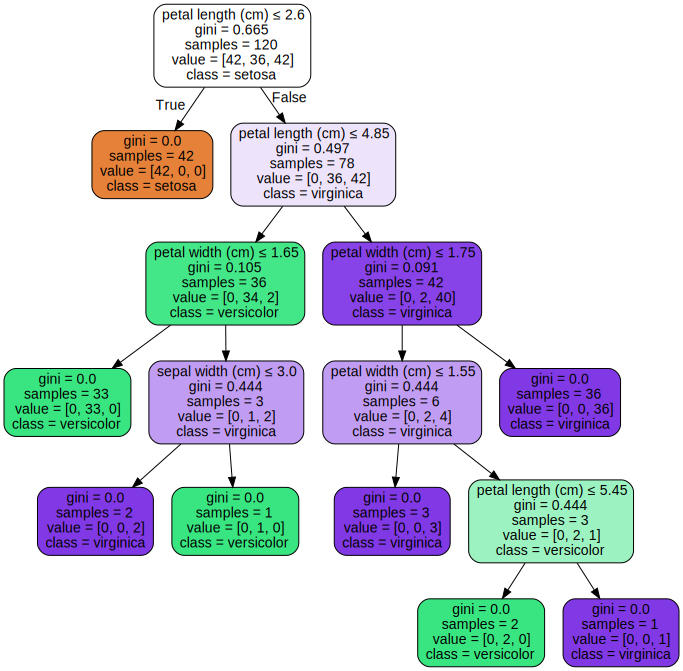

In [55]:
# TODO: Import mô hình và dữ liệu cần thiết từ thư viện
import numpy as np
from sklearn import datasets 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn import tree

iris = datasets.load_iris()
data = iris.data
target = iris.target


# TODO: Chia dữ liệu huấn luyện và kiểm tra hợp lý
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

# TODO: Huấn luyện mô hình với dữ liệu
clf = dtc()
clf.fit(X_train, y_train)

# TODO: Visualize mô hình vừa được xây dựng với tập dữ liệu kiểm tra
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names,
                         class_names=iris.target_names,
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

# Các thuật toán xây dựng cây quyết định cơ bản

Vấn đề cơ bản của bài toán xây dựng cây quyết định là:
- Xác định thuộc tính/điều kiện của mỗi nút
- Thứ tự các nút

Trong bài này, chúng ta sẽ làm quen với 2 thuật toán cơ bản nhất là **ID3** (Iterative Dichotomiser 3) và **C4.5** (Classification and Regression Tree).

## ID3

Thuật toán ID3 (Quinlan 1986) chọn thuộc tính tốt nhất của tập huấn luyện được làm nút gốc theo tiêu chuẩn cực đại lượng thu hoạch thông tin (Information Gain). 

### Entropy
Entropy dùng để đo độ không chắc chắn (độ mù mờ của thông tin). Nếu ta tập dữ liệu $D$ có $N$ phần tử, thuộc $C$ lớp và số phần tử mỗi lớp là $N_c$ thì entropy của tập dữ liệu $D$ được tính theo công thức:

$$ E(D) = - \sum_{c=1}^{C} \frac{N_c}{N}\log (\frac{N_c}{N}) = - \sum_{c=1}^{C}p_c\log(p_c)$$
**Bài tập**: Định nghĩa hàm `entropy(freq)` để tính entropy của phân phối xác suất dữ liệu `freq`.


In [2]:
# TODO: Để có thể xây dựng được cây quyết định, việc đầu tiên cần làm là tính 
#       toán entropy cho dữ liệu với một phân phối cho trước (hoặc được tính
#       toán thông qua dữ liệu)
#       Định nghĩa hàm entropy(freq) tính toán độ mù mờ của dữ liệu với phân 
#       phối xác suất freq, là tần suất của mỗi lớp c trong bộ dữ liệu D. Hàm trả về số thực là độ đo entropy tương ứng.
import numpy as np
def entropy(freq):
    ent = 0
    for p in freq:
        if (p > 0 and p <= 1):
            ent -= p * np.log2(p)
    return ent

freq = np.array([0.2, 0.3, 0.12, 0.18, 0.08, 0.06, 0.06])
print("Entropy = {}".format(entropy(freq)))

# Kết quả xấp xỉ 1.786

Entropy = 2.5764258916820024


### Entropy hai thuộc tính
Khi thuộc tính $x_i$ được chọn làm nút, chia tập $D$ thành $K$ nhánh con $D_1, D_2,...,D_k$, số lượng phần tử trong mỗi nốt con kí hiệu là $m_k$. Độ đo entropy  sau phép chia này được tính:
$$ E(D,x_i) = \sum_{k=1}^{K} \frac{m_k}{N}E(D_k)= \sum_{k\in K}P(k)E(D_k) $$

**Bài tập:** Tính độ đo entropy khi có thêm một thuộc tính.

In [50]:
# TODO: Khi chọn thêm một thuộc tính làm nốt chia, ta phải tính entropy với
#       thuộc tính mới để tìm ra thuộc tính chia tốt nhất.
#       Định nghĩa hàm _entropy(data, target, target_attr):
#       - data (np.array): tập dữ liệu ban đầu
#       - target(np.array): tập nhãn tương ứng với dữ liệu
#       - target_attr(id): thuộc tính chia cần tính entropy
# Gợi ý: Sử dụng lại hàm entropy()

def _entropy(data, target, target_attr):
    length, width = data.shape
    val_attr = data[:, target_attr]
    
    # tính entropy cho tập dữ liệu đầy đủ ban đầu
    ent_full = None
    target_prob = {}
    for tar in target:
        if (tar in target_prob):
            target_prob[tar] += 1.0/length
        else:
            target_prob[tar] = 1.0/length
    ent_full = entropy(target_prob.values())
    

    # chia nhỏ tập dữ liệu với thuộc tính chia
    # mỗi giá trị của thuộc tính chia chia tập dữ liệu thành 1 tập con
    sorted_index = np.argsort(val_attr)
    
    # tính entropy khi biết thêm thông tin về thuộc tính chia (công thức tính E(D,xi))
    _ent = -1
    
    for i in range(length):
        if val_attr[sorted_index[i]] > val_attr[sorted_index[i-1]]:
            ent_left = None
            ent_right = None
            prob_left = {}
            prob_right = {}
            for idx in range(i):
                if target[sorted_index[idx]] in prob_left:
                    prob_left[target[sorted_index[idx]]] += 1.0/i
                else:
                    prob_left[target[sorted_index[idx]]] = 1.0/i
            
            for idx in range(i, length):
                if target[sorted_index[idx]] in prob_right:
                    prob_right[target[sorted_index[idx]]] += 1.0/(length-i)
                else:
                    prob_right[target[sorted_index[idx]]] = 1.0/(length-i)
            
            ent_left = entropy(prob_left.values())
            ent_right = entropy(prob_right.values())
            ent = (ent_left*i + ent_right*(length-i))/length
            
            if _ent == -1:
                 _ent = ent
            elif ent < _ent:
                _ent = ent
                
    return _ent

# Giả sử tập dữ liệu đã được chia bởi thuộc tính đầu tiên: Độ dài của lá
iris_entropy = _entropy(data, target, 0)
print("Entropy with iris: {}".format(iris_entropy))

Entropy with iris: 1.0277298129142294


### Độ thu hoạch thông tin
Độ thu hoạch thông tin được tính là độ giảm entropy khi biết thêm một thông tin $x$:
$$ Gain(D,x_i) = G(D,x_i)= E(D) - E(D,x_i) $$

Thuộc tính nào cho độ mù mờ thông tin (entropy) nhỏ nhất hay có độ thu hoạch thông tin lớn nhất sẽ được chọn làm thuộc tính tại nút.

$$ x^* = \underset{x}{\arg\max}G(D,x_i) = \underset{x}{\arg\min}E(D,x_i) $$
**Bài tập:** Viết hàm tính độ thu hoạch thông tin khi thử chọn một thuộc tính làm thuộc tính chia.


In [52]:
# TODO: Dựa vào công thức ở trên, định nghĩa hàm gain(data, target, new_attr) tính độ
#       thu hoạch thông tin khi chia nhỏ tập dữ liệu theo thuộc tính mới.
def gain(data, target, new_attr):
    # Tính entropy của tập dữ liệu
    length, width = data.shape
    
    
    # tính entropy cho tập dữ liệu đầy đủ ban đầu
    ent_full = None
    target_prob = {}
    for tar in target:
        if (tar in target_prob):
            target_prob[tar] += 1.0/length
        else:
            target_prob[tar] = 1.0/length
    ent_full = entropy(target_prob.values())
    
    # Tính entropy khi tập dữ liệu bị chia bởi thuộc tính mới
    # Khi chọn thuộc tính lần thứ nhất, thuộc tính chia được chọn trước đó có id = -1
    data_entropy_divide = _entropy(data, target, new_attr)
    
    # Tính độ thu hoạch thông tin
    gain_infor = ent_full - data_entropy_divide
    
    return gain_infor


0.557232687807


**Bài tập:** Với tập dữ liệu hoa cẩm chướng ban đầu, chọn ra thuộc tính chia tốt nhất.

In [56]:
# TODO: Dựa vào các hàm đã xây dựng trước đó, chọn ra nút gốc cho cây quyết định
#       của hoa cẩm chướng (trả về chỉ số của thuộc tính trong tập dữ liệu)

# chọn thuộc tính tốt nhất với thuật toán ID3
best_attr = 0
maxGain = -1
length, width = data.shape
for i in range(width):
    gainInfor = gain(data, target, i)
    if gainInfor > maxGain:
        maxGain = gainInfor
        best_attr = i
    
print("Best attribute can be used: {}".format(best_attr))

Best attribute can be used: 2


## C4.5
Thuật toán C4.5 được đề xuất năm 1993 bởi Quinlan nhằm khắc phục điểm yếu của thuật toán ID3: áp dụng Tỷ lệ thu hoạch thông tin cực đại (Gain Ratio).

Tỷ lệ thu hoạch này phạt các thuộc tính có nhiều giá trị bằng cách thêm vào một hạng tử gọi là `thông tin chia` (Split Information), đại lượng này rất nhạy cảm với việc đánh giá tính rộng và đồng nhất khi chia tách dữ liệu theo giá trị thuộc tính:
$$ SplitInformation(D,x_i)=-\sum_{i=1}^{k} \frac{\left|D_i\right|}{\left|D\right|} \log{\frac{\left|D_i\right|}{\left|D\right|}}$$
`Split Information` thực tế là entropy của tập dữ liệu `D` ứng với thuộc tính chia `x_i`.

Khi đó, tỷ lệ thông tin chia được tính bằng cách chia độ thu hoạch thông tin cho thông tin chia.
$$ GainRatio(D, x_i) = \frac{Gain(D,x_i)}{SplitInformation(D,x_i)} $$

**Bài tập:** Hoàn thành hàm `split_infor()` tính thông tin chia và hàm `gain_ratio()` để tỷ lệ thu hoạch thông tin.

In [6]:
# TODO: Định nghĩa hai hàm split_infor(...) và gain_ratio(...) để cải thiện thuật toán 
#       ID3 theo ý tưởng của C4.5
def split_infor(data, new_attr):
    # chia dữ liệu ban đầu thành các tập nhỏ với new_attr
    split_sets = None
    
    # tính độ chia thông tin
    split_inf = None
    return split_inf

def gain_ratio(data, target, new_attr):
    # tính độ thu hoạch thông tin
    gain_infor = None
    
    # tính độ chia thông tin
    split_inf = None
    
    # áp dụng công thức, ta có tỷ lệ thông tin chia
    gain_ratio = None
    
    return gain_ratio

**Bài tập:** *Dựa trên việc cải thiện thuật toán ID3, chọn lại nút gốc cho cây quyết định với dữ liệu hoa cẩm chướng*

In [7]:
# TODO: Dựa vào các hàm đã xây dựng trước đó, chọn ra nút gốc cho cây quyết định
#       của hoa cẩm chướng (trả về chỉ số của thuộc tính trong tập dữ liệu)

# chọn thuộc tính tốt nhất với thuật toán C4.5
best_attr = None
print("Best attribute can be used: {}".format(best_attr))

Best attribute can be used: None
